# Изучение рынка компьютерных игр

## Описание проекта

Для определения популярных продуктов, оценки их потенциала и планирования рекламных кампаний, интернет-магазину необходимо провести исследование. Анализ проводится на основе исторических данных о продажах игр, оценок пользователей и экспертов, доступных в открытых источниках. В датасете перечислены игры, выходившие до 2016 года. Нужно изучить их, выявить наиболее перспективные направления и определить влияющие на продажи факторы.

**Цель проекта**

Выявить факторы, определяющие успешность игры и, возможно, способствующие высоким продажам.

**Задачи**

1. Изучить исходный датасет на предмет корректного типа данных, отсутствующих значений, наличия дубликатов и прочих несоответствий.
2. Обработать данные там, где это необходимо, и рассчитать нужные для дальнейшего анализа параметры.
3. Изучить общую статистику по продажам игр в разрезах по годам, платформам и жанрам.
4. Рассмотреть, как меняется портрет пользователя в зависимости от региона.
5. Сформулировать гипотезы о пользовательских рейтингах платформ и жанров и провести проверку этих гипотез.

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
games = pd.read_csv('/datasets/games.csv')
display(games.head(10))
print(games.info())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Посмотрим, какова доля пропущенных значений во всех столбцах датафрейма.

In [3]:
print(games.isnull().sum() / len(games))

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64


Количество пропусков в трех последних столбцах большое. Позже проанализируем их, чтобы принять решение об их дальнейшей судьбе.

Выведем основные статистические показатели по столбцам.

In [4]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Приведем заголовки столбцов к нижнему регистру.

In [5]:
games.columns = games.columns.str.lower()

Столбец user_score имеет тип данных object, хотя там указаны числа. Проверим, нет ли там кроме чисел строковых значений.

In [6]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
9.6       2
1.5       2
2.3       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

В колонке много ячеек со значением 'tbd'. В пояснениях к проекту не сказано, что означает эта аббревиатура. Сделаем предположение, что tbd - это аббревиатура от английского "To Be Determined" (будет определено). Т.е., возможно, рейтинг игры до сих пор не определен (не набрал нужного количества отзывов) или сначала был tbd, а потом забыли поменять показатели. 
Посчитаем их долю в датасете.

In [7]:
(games[games['user_score'] == 'tbd']['user_score'].count() / len(games)).round(2)

0.15

Доля этих значений немаленькая, к тому же из-за них python рассматривает этот столбец как тип данных object. В следующем разделе значение будет обработано.

Посмотрим, какие рейтинги имеют представленные в датасете игры.

In [8]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Проверим, имеются ли в наборе явные дубликаты.

In [9]:
print('Количество дубликатов в наборе данных: {}'.format(games.duplicated().sum()))

Количество дубликатов в наборе данных: 0


### Вывод

В наборе данных 16715 строк и 11 столбцов.

Доля пропущенных значений в столбцах name (0,01%), year_of_release (1,61%) и genre (0,012%) невелика. Такие записи можно удалить.

В датафрейме большое количество пропусков в столбцах critic_score (51,3% от всех данных), user_score (примерно 40,1%) и rating (40,5%). Это половина датасета, что будет представлять большую трудность при дальнейшем анализе. Что делать с пропусками - пока не совсем понятно. Простое их удаление заберет у нас половину датасета. При замене их средним или медианным значением есть риск "разбавить" возможные корреляции ничего не значащими данными так, что потом никакие зависимости невозможно будет найти.

В некоторых колонках данные представлены некорректными типами: year_of_release в формате float, а нужно datetime, user_score в формате object вместо float.

В столбце user_score много значений tbd (порядка 14,5%).

Для удобства обработки данных все заголовки сразу приведены к нижнему регистру.

Явных дубликатов в наборе данных не выявлено.

## Подготовка данных

### Обработка пропущенных значений

Записи с NaN в столбцах name, year_of_release и genre удаляем, поскольку их немного.

In [10]:
games.dropna(subset = ['name', 'year_of_release', 'genre'], inplace=True)

Другое дело - пропущенные значения в оценках пользователей и критиков, а также в рейтинге. Количество NaN 40-51%% в столбцах, да плюс еще 14,5% значений tbd в user_score - это очень много. Здесь нет хороших решений. 

С одной стороны, если заменить пропуски в таком количестве средним или медианой, то можно размыть все зависимости между параметрами и не найти каких-то важных закономерностей. К тому же на графике распределения у нас вырастет огромный пик в районе среднего или медианы.

С другой, оставляя NaN необработанными, будет сложно привести данные к нужному формату и работать с ними. 

Третий вариант - удаление всех пропусков. В этом случае датасет будет чистый, но маленький. Кроме того, "за компанию" пострадают заполненные колонки с доходами по разным регионам. Эти данные нам нужны для анализа, но мы их лишаемся из-за NaN в других столбцах. 

Четвертый вариант - попробовать найти некоторые закономерности/ отношения между годом выпуска, продажами по регионам и оценками, и на основании этого заполнить датасет. Но здесь мы рискуем сами создать / усилить корреляции, которые потом с радостью обнаружим на последующем этапе анализа. А других колонок, которые мы могли бы использовать в качестве источника информации для заполнения, у нас нет.

Возможно, в этом кейсе оптимальным решением будет сохранить пропуски, только заменить тип данных в столбце user_score и убрать значение tbd. А в колонке rating отсутствующие показатели заменим на undefined.

Вероятно, появление пропусков связано с тем, что игры с NaN в этих столбцах вышли слишком давно (например, в восьмидесятых годах), когда система оценок и рейтингов еще не сложилась. 
Проверим наше предположение, посчитав долю пропущенных значений по годам выпуска игры.

In [11]:
print((games[games['critic_score'].isnull()]).groupby('year_of_release')['year_of_release'].count() / games.groupby('year_of_release')['year_of_release'].count())

year_of_release
1980.0    1.000000
1981.0    1.000000
1982.0    1.000000
1983.0    1.000000
1984.0    1.000000
1985.0    0.928571
1986.0    1.000000
1987.0    1.000000
1988.0    0.933333
1989.0    1.000000
1990.0    1.000000
1991.0    1.000000
1992.0    0.976744
1993.0    1.000000
1994.0    0.991736
1995.0    1.000000
1996.0    0.969582
1997.0    0.941176
1998.0    0.926121
1999.0    0.884615
2000.0    0.591429
2001.0    0.323651
2002.0    0.243667
2003.0    0.245161
2004.0    0.263780
2005.0    0.302449
2006.0    0.383698
2007.0    0.421888
2008.0    0.498949
2009.0    0.543478
2010.0    0.601594
2011.0    0.559859
2012.0    0.508423
2013.0    0.498162
2014.0    0.550775
2015.0    0.628713
2016.0    0.537849
Name: year_of_release, dtype: float64


Да, примерно до 2000 года такие оценки не применялись. Но интересно, что доля пропусков в самом начале 2000-х снизилась, а с 2006-2007 начала опять расти. Возможно, связано с тем, что самих игр становится все больше, и критики уже не обозревают все игры в ассортименте, а выделяют самые значимые из них.

Посмотрим, что происходит со столбцами пользовательских оценок и рейтингом.

In [12]:
print((games[games['user_score'].isnull()]).groupby('year_of_release')['year_of_release'].count() / games.groupby('year_of_release')['year_of_release'].count())

year_of_release
1980.0    1.000000
1981.0    1.000000
1982.0    1.000000
1983.0    1.000000
1984.0    1.000000
1985.0    0.928571
1986.0    1.000000
1987.0    1.000000
1988.0    0.933333
1989.0    1.000000
1990.0    1.000000
1991.0    1.000000
1992.0    0.976744
1993.0    1.000000
1994.0    0.991736
1995.0    1.000000
1996.0    0.969582
1997.0    0.934256
1998.0    0.918206
1999.0    0.884615
2000.0    0.571429
2001.0    0.296680
2002.0    0.208685
2003.0    0.211613
2004.0    0.217848
2005.0    0.250266
2006.0    0.328032
2007.0    0.314119
2008.0    0.308339
2009.0    0.285414
2010.0    0.364143
2011.0    0.367958
2012.0    0.444104
2013.0    0.413603
2014.0    0.397590
2015.0    0.447195
2016.0    0.410359
Name: year_of_release, dtype: float64


In [13]:
print((games[games['rating'].isnull()]).groupby('year_of_release')['year_of_release'].count() / games.groupby('year_of_release')['year_of_release'].count())

year_of_release
1980.0    1.000000
1981.0    1.000000
1982.0    1.000000
1983.0    1.000000
1984.0    1.000000
1985.0    0.928571
1986.0    1.000000
1987.0    1.000000
1988.0    0.933333
1989.0    1.000000
1990.0    1.000000
1991.0    1.000000
1992.0    0.953488
1993.0    1.000000
1994.0    0.991736
1995.0    1.000000
1996.0    0.973384
1997.0    0.934256
1998.0    0.915567
1999.0    0.875740
2000.0    0.577143
2001.0    0.296680
2002.0    0.209891
2003.0    0.209032
2004.0    0.215223
2005.0    0.248136
2006.0    0.326044
2007.0    0.314119
2008.0    0.312544
2009.0    0.291024
2010.0    0.363347
2011.0    0.381162
2012.0    0.456355
2013.0    0.419118
2014.0    0.406196
2015.0    0.480198
2016.0    0.442231
Name: year_of_release, dtype: float64


С пользовательскими оценками ситуация похожая, примерно до 2000 года оценок мало. Но доля пропущенных значений после провала в 2000х здесь растет гораздо медленнее, чем у критиков. Возможно, потому, что юзеров гораздо больше и они оценивают игры активнее профессионалов. Что касается рейтингов, то ESRB была основана только в 1994 году. Соответсвенно, до этого года рейтинг вообще не присваивался.

Заменим пропуски в колонке rating на значение 'undefined'.

In [14]:
games['rating'] = games['rating'].fillna('undefined')
print(games['rating'].value_counts())

undefined    6676
E            3921
T            2905
M            1536
E10+         1393
EC              8
K-A             3
RP              1
AO              1
Name: rating, dtype: int64


### Замена типов данных, преобразование таблиц

Изменим тип данных в основном датасете, колонки user_score и year_of_release. Функции to_numeric передадим параметр errors='coerce', чтобы заменить tbd на NaN.

In [15]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
games['year_of_release'] = pd.to_datetime(games['year_of_release'], format = '%Y')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null datetime64[ns]
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             16444 non-null object
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.5+ MB


Посчитаем общие продажи по всем регионам и сохраним полученные значения в отдельном столбце.

In [16]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Вывод

Пропущенные значения в столбцах name, year_of_release и genre были удалены. Что касается огромного количества пропусков в колонках critic_score (51,3% от всех данных), user_score (примерно 40,1%), то здесь оставили пропуски, а значение tbd в user_score поменяли на NaN.

NaN во многих оценках пользователей и критиков, скорее всего, появились из-за того, что игра вышла рано (80е годы), когда система оценивания, как таковая, еще не сложилась. Не было в достаточном количестве специалистов, способных оценить качество продукта. Не было и площадок, где можно было делиться мнениями.

В столбцах year_of_release и user_score типы данных заменены на datetime и float соответственно. 

В колонке raiting тип данных корректный, а значения представляют собой категориальные данные. NaN (40,5%) здесь поменяли на undefined.

## Исследовательский анализ данных

### Продажи по годам

Посчитаем, сколько игр выпускалось в разные годы.

In [18]:
games.groupby('year_of_release')['year_of_release'].count()

year_of_release
1980-01-01       9
1981-01-01      46
1982-01-01      36
1983-01-01      17
1984-01-01      14
1985-01-01      14
1986-01-01      21
1987-01-01      16
1988-01-01      15
1989-01-01      17
1990-01-01      16
1991-01-01      41
1992-01-01      43
1993-01-01      60
1994-01-01     121
1995-01-01     219
1996-01-01     263
1997-01-01     289
1998-01-01     379
1999-01-01     338
2000-01-01     350
2001-01-01     482
2002-01-01     829
2003-01-01     775
2004-01-01     762
2005-01-01     939
2006-01-01    1006
2007-01-01    1197
2008-01-01    1427
2009-01-01    1426
2010-01-01    1255
2011-01-01    1136
2012-01-01     653
2013-01-01     544
2014-01-01     581
2015-01-01     606
2016-01-01     502
Name: year_of_release, dtype: int64

Восьмидесятые точно не могут похвастаться игровым разнообразием, бурный рост начнется позже. Но любопытно, что пик производства игр (в количестве наименований) как будто уже пройден. 

Построим гистограмму распределния выпуска игр по годам.

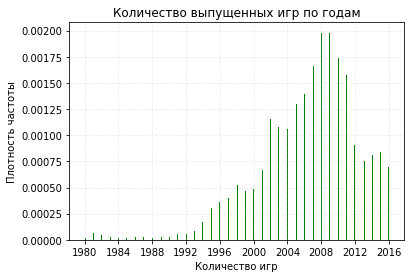

In [19]:
plt.hist(games['year_of_release'], density=True, bins=300, color='green', histtype='bar')
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Количество игр')
plt.ylabel('Плотность частоты')
plt.grid(alpha=0.2, linestyle='--', linewidth=1)

Судя по расчетам и графику, в 1992-1993 годах начался активный рост выпуска игр. Он достиг своего пика примерно в 2008-2009 годах. В 2012 году количество выпущенных игр резко снизилось (в 2 раза), а в последующие годы остается примерно на одном и том же уровне.
Предположительно связано с тем, что сфера усложняется, проекты становятся масштабнее и требуют больше времени на разработку.

Посмотрим, как менялись продажи по платформам.

### Продажи по платформам

#### Жизненный цикл платформ

Выделим десять платформ с наибольшими суммарными продажами за все время.

In [20]:
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64

Во главе рейтинга оказались платформы, которые хоть и принесли больше всех продаж, но сами уже давно устарели. А нам нужно, чтобы результаты нашего исследования характеризовали текущую ситуацию или хотя бы недалекое прошлое. 

Для определения актуального периода построим на график продаж платформ из Топ-10 по годам.

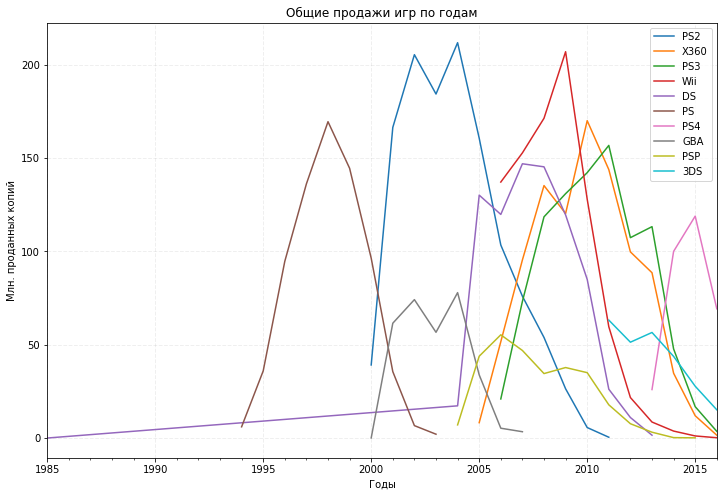

In [21]:
top10_platforms = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).index

fig, ax = plt.subplots(figsize=(12,8))
labels = []
for row in top10_platforms:
    platform = row
    games[games['platform'] == platform].groupby('year_of_release')['total_sales'].sum().plot(y='total_sales', x='year_of_release')
    labels.append(row)
ax.set_title('Общие продажи игр по годам')
ax.set_xlabel('Годы')
ax.set_ylabel('Млн. проданных копий')
ax.grid(alpha=0.2, linestyle='--', linewidth=1)
ax.legend(labels, loc='left')

Это график описывает взлет, пик и упадок продаж игр для самых популярных платформ. Примерное время жизни игровых консолей, когда их еще покупают, - 7-10 лет. А с момента выпуска предыдущей до выхода последущей версии платформы нового поколения проходит порядка 6-7 лет. Это период, когда появляются более современные и продвинутые технологии, и старые платформы уже "не тянут" новые игры.

Для нашего дальнейшего анализа возьмем половину примерного жизненного цикла платформы - это данные за последние 4 года. Актуальный период будет определен, начиная с 2013 года.

In [24]:
games = games.query('year_of_release >= 2013')

#### Корреляция продаж и оценок

Посмотрим, игры для каких платформ продавались с 2013 года. Выведем данные по продажам в штуках за последние четыре года.

In [25]:
platforms_after2013 = games.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')
platforms_after2013['total'] = platforms_after2013.sum(axis=1)
platforms_after2013 = platforms_after2013.sort_values(by='total', ascending=False)
display(platforms_after2013)

year_of_release,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,total
platform,,,,,
PS4,25.99,100.00,118.90,69.25,314.14
PS3,113.25,47.76,16.82,3.60,181.43
XOne,18.96,54.07,60.14,26.15,159.32
3DS,56.57,43.76,27.78,15.14,143.25
X360,88.58,34.74,11.96,1.52,136.80
WiiU,21.65,22.03,16.35,4.60,64.63
PC,12.38,13.28,8.52,5.25,39.43
PSV,10.59,11.90,6.25,4.25,32.99
Wii,8.59,3.75,1.14,0.18,13.66


В целом для всех платформ в нашем списке характерен нисходящий тренд, пик продаж пройден для всех моделей. Это означает, что продажи игр для этих консолей будут постепенно падать, пока не сойдут на нет. Жизненный цикл довольно короткий, технологии устаревают, появляется что-то более новое и активно пользующееся спросом. Совпадение циклов у платформ связано с тем, что и новинки выходят у них примерно в одно и то же время.

Построим боксплоты по глобальным продажам игр в разбивке по консолям.

Text(0, 0.5, 'Млн. проданных копий')

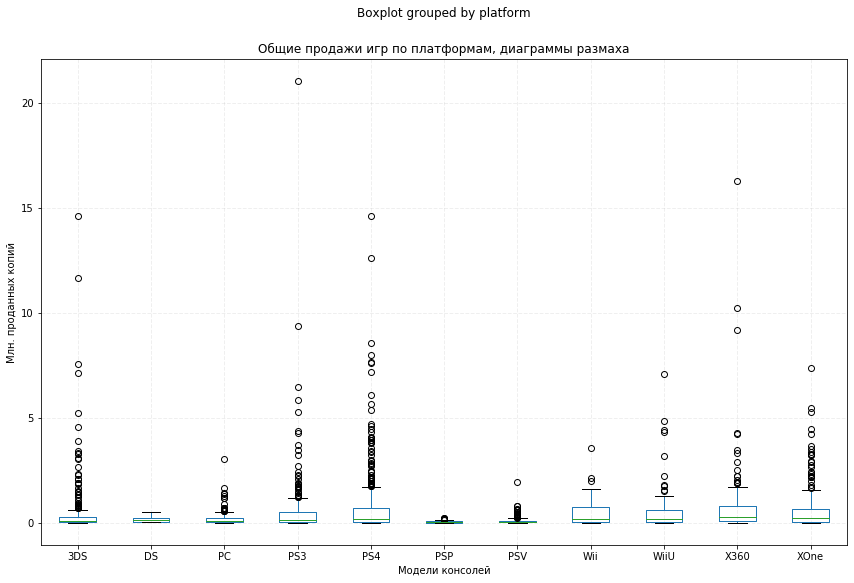

In [26]:
games.boxplot(column='total_sales', by='platform', figsize=(14,9))
plt.title('Общие продажи игр по платформам, диаграммы размаха')
plt.grid(alpha=0.2, linestyle='--', linewidth=1)
plt.xlabel('Модели консолей')
plt.ylabel('Млн. проданных копий')

Получившийся аквариум с боксплотами говорит нам о том, что большинство выходящих для платформ игр, являются довольно ординарными продуктами и не слишком обогащают своих создателей. Вероятно, часть из них являются даже убыточными, поскольку медианное значение ближе к нижней границе.

Считать ли все эти точки, вылетающие далеко за пределы "уса", выбросами? Их очень много, от верхнего порогового значения находятся крайне далеко, и характерны почти для каждого ящика. Скорее всего, это очень популярные, даже культовые игры, которые имеют поклонников по всему миру. Именно эти продукты могут делать большинство выручки для компаний, их производящих.
У Sony даже есть стратегия - выпуск эксклюзива исключительно для своих консолей, например, The Last of Us, Uncharted или Horizon Zero Dawn.
Именно по этим выбросам (самым продаваемым играм), как правило, и бывает большинство отзывов критиков и оценок зрителей. 

По этой причине выбросы не будем удалять, а лишь примем их как особенность индустрии, когда 20% игр дают 80% прибыли (а то и больше).

В пятерку лидеров нашего рейтинга по доходам за последние 4 года попали уже устаревшие платформы, такие как PS3 и X360. Делать прогнозы по продажам игр для платформ, которые вот-вот выйдут из оборота, не имеет смысла. Поэтому отсортируем наш рейтинг по столбцу продаж за 2016 год и выделим самые перспективные консоли.

In [27]:
display(platforms_after2013.sort_values(by=platforms_after2013.columns[-2], ascending=False).head(5))

year_of_release,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,total
platform,,,,,
PS4,25.99,100.00,118.90,69.25,314.14
XOne,18.96,54.07,60.14,26.15,159.32
3DS,56.57,43.76,27.78,15.14,143.25
PC,12.38,13.28,8.52,5.25,39.43
WiiU,21.65,22.03,16.35,4.60,64.63


В 2016 году лучше всего продавались игры для PS4, XOne и 3DS. Их-то мы и будем считать самыми перспективными.

Теперь посмотрим, есть ли зависимость между продажами и оценками критиков и пользователей. Платформа-лидер по продажам - PS4, на ее основе и построим диаграммы рассеяния.

Text(0.5, 0, 'Оценка')

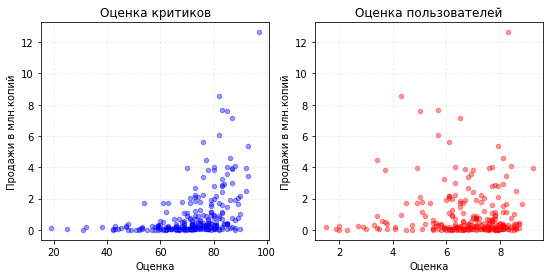

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

ax[0].scatter(games[games['platform'] == 'PS4']['critic_score'], games[games['platform'] == 'PS4']['total_sales'], color='blue', s=20, alpha=0.4)

ax[0].grid(alpha=0.2, linestyle='--', linewidth=1)
ax[0].set_title('Оценка критиков', fontsize='large')
ax[0].set_ylabel('Продажи в млн.копий')
ax[0].set_xlabel('Оценка')

ax[1].scatter(games[games['platform'] == 'PS4']['user_score'], games[games['platform'] == 'PS4']['total_sales'], color='red', s=20, alpha=0.4)
ax[1].grid(alpha=0.2, linestyle='--', linewidth=1)
ax[1].set_title('Оценка пользователей', fontsize='large')
ax[1].set_ylabel('Продажи в млн.копий')
ax[1].set_xlabel('Оценка')

Возможно, есть небольшая зависимость между оценками критиков и продажами. А вот корреляция пользовательских оценок с продажами не прослеживается. 

Попробуем совместить графики оценок пользователей и критиков. Для этого выровняем шкалы, умножив значения пользовательских оценок на 10 (чтобы оценки и критиков, и пользователей были по 100-бальной шкале). Построим диаграмму рассеяния.

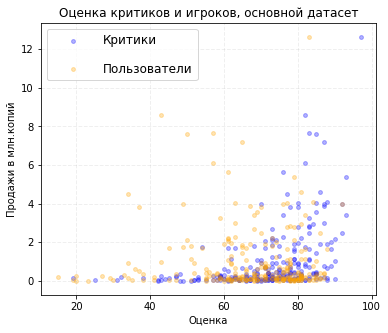

In [29]:
fig, ax = plt.subplots(figsize=(6,5))

ax.scatter(games[games['platform'] == 'PS4']['critic_score'], games[games['platform'] == 'PS4']['total_sales'], color='blue', s=15, alpha=0.3)
ax.scatter(games[games['platform'] == 'PS4']['user_score']*10, games[games['platform'] == 'PS4']['total_sales'], color='orange', s=15, alpha=0.3)
ax.grid(alpha=0.2, linestyle='--', linewidth=1)
ax.set_title('Оценка критиков и игроков, основной датасет', fontsize='large')
ax.set_ylabel('Продажи в млн.копий')
ax.set_xlabel('Оценка')
ax.legend(["Критики", "Пользователи"], loc=2, fontsize='large', labelspacing=1.3, handlelength=3.5)

В целом на диаграмме видно, что критики дают более профессиональную оценку (по крайней мере, с точки зрения продаж). Визуально их оценки сильнее коррелируют с продажами, чем у пользователей. Кроме того, критики ставят более высокие баллы, чем пользователи (хотя, возможно, им за это доплачивают).

Посчитаем, как оценки и продажи соотносятся между собой, выведем корреляционную матрицу.

In [30]:
print('\n', 'Корреляционная матрица, коэф. Пирсона')
display(games[games['platform'] == 'PS4'].corr().style.background_gradient(cmap='coolwarm'))


 Корреляционная матрица, коэф. Пирсона


,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
na_sales,1,0.785362,0.472981,0.944259,0.415008,-0.020933,0.92816
eu_sales,0.785362,1,0.464563,0.944698,0.34672,-0.0489248,0.958157
jp_sales,0.472981,0.464563,1,0.496467,0.322358,0.171332,0.527129
other_sales,0.944259,0.944698,0.496467,1,0.409191,-0.0356391,0.998051
critic_score,0.415008,0.34672,0.322358,0.409191,1,0.557654,0.406568
user_score,-0.020933,-0.0489248,0.171332,-0.0356391,0.557654,1,-0.0319571
total_sales,0.92816,0.958157,0.527129,0.998051,0.406568,-0.0319571,1


Оценка критиков лучше характеризует продажи (наблюдается небольшая положительная корреляция 0.41), чем оценка пользователей (почти нулевая корреляция на уровне -0.03).

Тем не менее в этом выводе есть, по крайней мере, два изъяна. Первый заключается в том, что коэффициент Пирсона чувствителен к выбросам, но мы не удаляли их из датасета. Второй - иногда закономерности могут носить нелинейный характер, и в этом случае коэффициент корреляции может оказаться бесполезным показателем.

Поэтому рассчитаем коэффициент ранговой корреляции Спирмена. Он более устойчив к выбросам и может определить некоторые типы нелинейной зависимости.
Используем тот же код, только функции corr передадим параметр method='spearman'.

In [31]:
print('\n', 'Корреляционная матрица, коэф. Спирмена')
display(games[games['platform'] == 'PS4'].corr(method='spearman').style.background_gradient(cmap='coolwarm'))


 Корреляционная матрица, коэф. Спирмена


,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
na_sales,1,0.808123,0.231602,0.940445,0.471392,-0.0849873,0.896344
eu_sales,0.808123,1,0.245849,0.927348,0.451354,-0.0308866,0.900919
jp_sales,0.231602,0.245849,1,0.24312,0.342327,0.178352,0.412517
other_sales,0.940445,0.927348,0.24312,1,0.496975,-0.0581336,0.956728
critic_score,0.471392,0.451354,0.342327,0.496975,1,0.433309,0.508238
user_score,-0.0849873,-0.0308866,0.178352,-0.0581336,0.433309,1,-0.0283403
total_sales,0.896344,0.900919,0.412517,0.956728,0.508238,-0.0283403,1


Коэффициент Спирмена оказался выше коэффициента Пирсона (положительная корреляция 0.51), оценка пользователей на уровне (-0.03), опять почти нулевая корреляция.

Посчитаем коэффициэнты корреляции Пирсона по всем платформам вместе.

In [32]:
print('Коэффициэнт Пирсона для отзывов критиков: {:.2f}'.format(games['critic_score'].corr(games['total_sales'])))
print('Коэффициэнт Пирсона для отзывов пользователей: {:.2f}'.format(games['user_score'].corr(games['total_sales'])))

Коэффициэнт Пирсона для отзывов критиков: 0.31
Коэффициэнт Пирсона для отзывов пользователей: -0.00


Выведем коэффициенты Спирмена для всех отзывов.

In [33]:
print('Коэффициэнт Спирмена для отзывов критиков: {:.2f}'.format(games['critic_score'].corr(games['total_sales'], method='spearman')))
print('Коэффициэнт Спирмена для отзывов пользователей: {:.2f}'.format(games['user_score'].corr(games['total_sales'], method='spearman')))

Коэффициэнт Спирмена для отзывов критиков: 0.43
Коэффициэнт Спирмена для отзывов пользователей: -0.01


В наборе данных наблюдается слабая положительная корреляция между количеством проданных копий и оценками критиков. Коэффициэнт Спирмена больше коэффициента Пирсона, вероятно, зависимость носит нелинейный характер. Взаимосвязь между количеством продаж и оценками пользователей настолько мала, что ею можно пренебречь.

### Продажи по жанрам

Посмотрим на общее распределение игр по жанрам.

In [34]:
games['genre'].value_counts()

Action          766
Role-Playing    292
Adventure       245
Sports          214
Shooter         187
Misc            155
Racing           85
Fighting         80
Platform         74
Simulation       62
Strategy         56
Puzzle           17
Name: genre, dtype: int64

Найдем наиболее популярные жанры. Для этого применим сводную таблицу, где в одной колонке посчитаем общее количество выпущенных игр в каждом жанре (c 2013 года), во второй - количество проданных копий по каждому жанру, а в третьей - среднее количество проданных копий на одну игру жанра.

In [35]:
genres = games.pivot_table(index='genre', values='total_sales', aggfunc=['count','sum','mean'])
genres = genres.sort_values(by=('sum', 'total_sales'), ascending=False).head(10)
display(genres)

,count,sum,mean
,total_sales,total_sales,total_sales
genre,,,
Action,766,321.87,0.420196
Shooter,187,232.98,1.245882
Sports,214,150.65,0.703972
Role-Playing,292,145.89,0.499623
Misc,155,62.82,0.405290
Platform,74,42.63,0.576081
Racing,85,39.89,0.469294
Fighting,80,35.31,0.441375


Самыми продаваемыми жанрами являются Action и Shooter (1 и 2 места соответственно). Интересно, что количество выпущенных игр (наименований игр) неодинаково соотносится с количеством их проданных копий. Например, шутеров всего 187 игр (это меньше, чем в жанрах на 3-5 местах), но в среднем количестве проданных копий на одну игру этот жанр обгоняет всех конкурентов. Хороший шутер принесет больше прибыли, чем спортивная игра или даже экшен.

### Вывод

По статистике продаж за 2016 год определены наиболее перспективные игры в разрезе платформ. Ими оказались продукты для PS4, XOne и 3DS.

Исследована зависимость между уровнем продаж и оценками критиков и пользователей. Если отзывы пользователей с продажами никак не связаны, то между количеством проданных копий и оценками критиков слабая положительная корреляция обнаружена. 

Для выявления зависимостей были использованы коэффициенты Пирсона и Спирмена. Коэффициент Пирсона чувствителен к выбросам, но мы не удаляли их из датасета. Ирония заключается в том, что, скорее всего, именно выбросы и будут интересовать заказчика исследования как самый популярный и продаваемый товар: он же хочет рекламную кампанию спланировать. И их удаление из датасета противоречит здравому смыслу.

Выведен список и самых продаваемых жанров. На первом месте Action, следом идут Shooter и Sports. И хотя экшен по общим продажам лидирует, среднее количество проданных копий на одну игру у шутеров гораздо выше. Это значит, что доля популярных игр среди шутеров больше, чем у победителя рейтинга.

## Изучение пользователей по регионам

### Популярные платформы

Для каждого региона составим свой Топ-5 платформ, которые продаются лучше всего.

In [36]:
platforms_regions = games.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
print('\n','В Северной Америке', '\n', platforms_regions.sort_values(by='na_sales', ascending=False)['na_sales'].head(5))
print('\n','В Европе', '\n', platforms_regions.sort_values(by='eu_sales', ascending=False)['eu_sales'].head(5))
print('\n','В Японии', '\n', platforms_regions.sort_values(by='jp_sales', ascending=False)['jp_sales'].head(5))
print('\n','В других странах', '\n', platforms_regions.sort_values(by='other_sales', ascending=False)['other_sales'].head(5))


 В Северной Америке 
 platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64

 В Европе 
 platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64

 В Японии 
 platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64

 В других странах 
 platform
PS4     48.35
PS3     26.77
XOne    14.27
X360    12.11
3DS      6.28
Name: other_sales, dtype: float64


В Северной Америке более всех популярна Play Station 4, хотя XOne и X360 там тоже сильно востребованы (второе и третье места соответсвенно).

Японцы любят Nintendo, часто покупают игрушки и для PS , но почему-то предпочитают третью модель, а не более современную четвертую. Вероятно, на руках у населения сохранилось очень много ранее купленных консолей, и пользователи пока не считают нужным их менять. Вообще Топ-5 для страны восходящего солнца вышел очень патриотичным, там присутствуют платформы только от своих компаний. 

Жители Европы и остального мира более космополитичны в своих предпочтениях и покупают консоли разных производителей. Однако, детище Sony они предпочитают остальным, верхушку рейтинга занимают PS4 и PS3. 

### Популярные жанры

Выявим самые популярные жанры игр (Топ-5) в разных регионах.

In [37]:
platforms_genres = games.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
print('\n','В Северной Америке', '\n', platforms_genres.sort_values(by='na_sales', ascending=False)['na_sales'].head(5))
print('\n','В Европе', '\n', platforms_genres.sort_values(by='eu_sales', ascending=False)['eu_sales'].head(5))
print('\n','В Японии', '\n', platforms_genres.sort_values(by='jp_sales', ascending=False)['jp_sales'].head(5))
print('\n','В других странах', '\n', platforms_genres.sort_values(by='other_sales', ascending=False)['other_sales'].head(5))


 В Северной Америке 
 genre
Action          126.05
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49
Name: na_sales, dtype: float64

 В Европе 
 genre
Action          118.13
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19
Name: eu_sales, dtype: float64

 В Японии 
 genre
Role-Playing    51.04
Action          40.49
Misc             9.20
Fighting         7.65
Shooter          6.61
Name: jp_sales, dtype: float64

 В других странах 
 genre
Action          37.20
Shooter         28.77
Sports          19.45
Role-Playing    11.48
Misc             6.09
Name: other_sales, dtype: float64


В целом предпочтения по игровым жанрам в мире однородны. Практически везде на первых местах Action, 
Shooter и Sports. Но на общем фоне сильно выделяется Япония, топ там другой. Экшен, правда, любят и здесь, но вот к шутерам и спортивным играм равнодушны. Их рейтинг Role-Playing, Action и Misc. 

### Рейтинг ESRB

Посмотрим, игры каких рейтингов особенно популярны (в разрезе регионов).

In [38]:
rating_regions = games.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
print('\n','В Северной Америке', '\n', rating_regions.sort_values(by='na_sales', ascending=False)['na_sales'].head(5))
print('\n','В Европе', '\n', rating_regions.sort_values(by='eu_sales', ascending=False)['eu_sales'].head(5))
print('\n','В Японии', '\n', rating_regions.sort_values(by='jp_sales', ascending=False)['jp_sales'].head(5))
print('\n','В других странах', '\n', rating_regions.sort_values(by='other_sales', ascending=False)['other_sales'].head(5))


 В Северной Америке 
 rating
M            165.21
undefined     89.42
E             79.05
E10+          54.24
T             49.79
Name: na_sales, dtype: float64

 В Европе 
 rating
M            145.32
E             83.36
undefined     78.91
E10+          42.69
T             41.95
Name: eu_sales, dtype: float64

 В Японии 
 rating
undefined    85.05
T            20.59
E            15.14
M            14.11
E10+          5.89
Name: jp_sales, dtype: float64

 В других странах 
 rating
M            47.04
undefined    23.46
E            22.61
T            14.29
E10+         12.57
Name: other_sales, dtype: float64


Регионы разные, но предпочтения у всех аналогичные (кроме одной страны). 
Практически везде лидируют игры с рейтингом «M» («Для взрослых», содержание не подходит для детей и подростков младше 17 лет). Второе место у игр с рейтингом «E» («Для всех», от 6 лет и старше) или у большой загадочной группы undefined (именно этим значением мы заменили пропуски в столбце rating). Следом идут игры «T» («Подросткам», для лиц от 13 лет). Замыкают рейтинг категория «E10+» («Для всех от 10 лет и старше»). А вот игры с рейтингом «EC» («Для детей младшего возраста» от 3 лет) в наши топы вообще не попали. Да, маленькие дети не так уж и часто играют в видеоигры.

В Японии картина несколько иная. Здесь на первом месте категория, созданная из NaN, т.е. жанр неизвестен. Если не принимать ее в расчет, то лидируют игры для всех и подростков. А вот категория "Для взрослых" лишь на четвертом месте. Видимо, взрослые слишком много работают.

### Вывод

Поведение пользователей Северной Америки и Европы, в целом, сходно. Как правило, за последние четыре года предпочтение отдавалось Play Station 4, следом идет Play Station 3 или Xbox One, среди жанров - Action, Shooter или Sports, а наиболее популярные игры рассчитаны на взрослую аудиторию.

А вот Япония сильно отличается от остального мира, причем по всем выбранным для сравнения параметрам сразу. Здесь более популярны игры для всей семьи и подростков, шутеры и спорт не в почете (лучше сыграем в какой-нибудь Role-Playing), а среди платформ котируются только японские (особенно Nintendo). Удивительно, но относительно современная PS4 в их топе занимает лишь четвертое место, хотя в рейтинге всех других регионов является лидером.

## Проверка гипотез

### Пользовательские рейтинги платформ

Определим, отличаются ли пользовательские рейтинги самых популярных платформ друг от друга. 

<div style="border: solid green 2px; padding: 10px">
За основу возьмем <strong>нулевую гипотезу</strong>, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Вернее, все выявленные отличия можно объяснить случайностью. 

<strong>Альтернативная гипотеза</strong> будет заключатся в том, что с большой (или значительной) вероятностью найденные отличия не случайны, и средние пользовательские рейтинги платформ Xbox One и PC отличаются друг от друга.
</div>

Для сопоставления двух групп сначала подготовим два датасета: один для платформы Xbox One, другой для PC.

In [39]:
games_xbox = games[games['platform'] == 'XOne']
games_pc = games[games['platform'] == 'PC']

Взглянем на гистограмму распределений рейтингов по платформам.

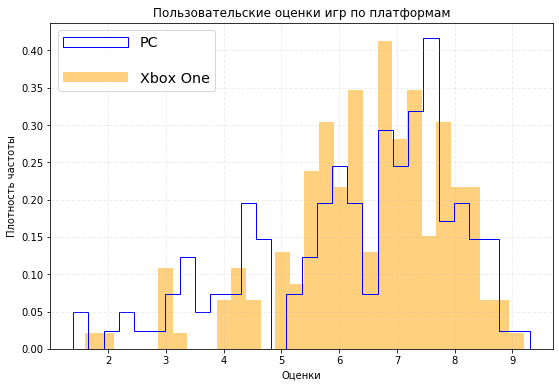

In [40]:
fig, ax = plt.subplots(figsize=(9,6))

ax.hist(games_xbox['user_score'], density=True, bins=30, color='orange', alpha=0.5)
ax.hist(games_pc['user_score'], density=True, bins=30, color='blue', histtype='step')
ax.set_title('Пользовательские оценки игр по платформам')
ax.set_xlabel('Оценки')
ax.set_ylabel('Плотность частоты')
ax.grid(alpha=0.2, linestyle='--', linewidth=1)
ax.legend(["PC", "Xbox One"], loc=2, fontsize='x-large', labelspacing=1.5, handlelength=4.5)

Два распределния похожи, но графики немного смещены относительно друг друга. Есть небольшая отрицательная скошенность влево. Это значит, что среднее сместится туда же.

Посчитаем среднее значение по выборке.

In [41]:
print('Cредняя оценка пользователей, XOne {:.2f}'.format(games_xbox['user_score'].mean()))
print('Cредняя оценка пользователей, PC {:.2f}'.format(games_pc['user_score'].mean()))

Cредняя оценка пользователей, XOne 6.52
Cредняя оценка пользователей, PC 6.27


В среднем, пользователи оценивают две платформы примерно одинаково. Но, поскольку наши группы могут считаться только выборочными совокупностями (хотя бы по той причине, что многие записи были удалены из-за отсутствующих значений), то истинное среднее может быть каким-то другим числом, а не тем, что мы нашли. Расчитаем доверительный интервал для истинного среднего (mu).

In [42]:
print('Доверительный интервал для истинного среднего, XOne', (st.t.interval(0.95, len(games_xbox['user_score'].dropna())-1, loc=np.mean(games_xbox['user_score'].dropna()), scale=st.sem(games_xbox['user_score'].dropna()))))
print('Доверительный интервал для истинного среднего, PC', (st.t.interval(0.95, len(games_pc['user_score'].dropna())-1, loc=np.mean(games_pc['user_score'].dropna()), scale=st.sem(games_pc['user_score'].dropna()))))

Доверительный интервал для истинного среднего, XOne (6.319452023663737, 6.723405119193408)
Доверительный интервал для истинного среднего, PC (5.993205025870744, 6.546149812838935)


С вероятностью 0.95 истинное среднее находится в этих пределах. 
Посмотрим, как сильно отличаются дисперсии двух групп. Используем в формуле параметр ddof=1 (для коррекции количества степеней свободы на n-1).

In [43]:
print('Дисперсия пользовательских оценок, XOne: {:.2f}'.format(np.var(games_xbox['user_score']), ddof=1))
print('Дисперсия пользовательских оценок, PC: {:.2f}'.format(np.var(games_pc['user_score']), ddof=1))
print('Отношение дисперсий XOne и PC: {:.2f}'.format(np.var(games_pc['user_score']) / np.var(games_xbox['user_score'])))

Дисперсия пользовательских оценок, XOne: 1.90
Дисперсия пользовательских оценок, PC: 3.02
Отношение дисперсий XOne и PC: 1.59


Рассчитаем стандартное отклонение для двух платформ. Также используем параметр ddof=1.

In [44]:
print('Стандартное отклонение, XOne: {:.2f}'.format(np.std(games_xbox['user_score'], ddof=1)))
print('Стандартное отклонение, PC: {:.2f}'.format(np.std(games_pc['user_score'], ddof=1)))

Стандартное отклонение, XOne: 1.38
Стандартное отклонение, PC: 1.74


Поскольку уровень значимости для проверки гипотез чувствителен к экстремальным значениям, с помощью правила "трех сигм" определим наличие выбросов в оценках пользователей и удалим их.

По правилам сигмы откладываются влево и вправо от математического ожидания, расположение которого нам неизвестно. С одной стороны, у нас есть выборочное среднее и скорректированное для выборки стандартное отклонение. Последнее значение, имеющие в своем знаменателе n-1 вместо n должно быть больше настоящего отклонения и компенсировать незнание разницы между выборочным и истинным средним. С другой - скорее всего, наше распределение не является симметричным и правильным. Поэтому немного отодвинем границы выбросов от среднего и отложим по три стандартных отклонения (рассчитанных по нашей выборке) с двух сторон не от выборочного среднего, а от границ доверительнго интервала для математического ожидания.

Посчитаем интервал, куда должны уложиться до 99% значений.

In [45]:
low = st.t.interval(0.95, len(games_xbox['user_score'].dropna())-1, loc=np.mean(games_xbox['user_score'].dropna()), scale=st.sem(games_xbox['user_score'].dropna()))[0] - (np.std(games_xbox['user_score'].dropna(), ddof=1))*3
up = st.t.interval(0.95, len(games_xbox['user_score'].dropna())-1, loc=np.mean(games_xbox['user_score'].dropna()), scale=st.sem(games_xbox['user_score'].dropna()))[1] + (np.std(games_xbox['user_score'].dropna(), ddof=1))*3
print('Границы выбросов для XOne {:.2f}'.format(low), '{:.2f}'.format(up))

low = st.t.interval(0.95, len(games_pc['user_score'].dropna())-1, loc=np.mean(games_pc['user_score'].dropna()), scale=st.sem(games_pc['user_score'].dropna()))[0] - (np.std(games_pc['user_score'].dropna(), ddof=1))*3
up = st.t.interval(0.95, len(games_pc['user_score'].dropna())-1, loc=np.mean(games_pc['user_score'].dropna()), scale=st.sem(games_pc['user_score'].dropna()))[1] + (np.std(games_pc['user_score'].dropna(), ddof=1))*3
print('Границы выбросов для PC {:.2f}'.format(low), '{:.2f}'.format(up))

Границы выбросов для XOne 2.18 10.87
Границы выбросов для PC 0.77 11.77


Посмотрим, сильно ли будут отличатся границы для выбросов, расчитанные как 1,5 межквартильного размаха (как если бы мы построили боксплоты).

In [46]:
outliers_up = ((games_xbox['user_score'].describe()['75%'] - games_xbox['user_score'].describe()['25%'])*1.5 + games_xbox['user_score'].describe()['75%']).round(1)
outliers_down = (games_xbox['user_score'].describe()['25%'] - (games_xbox['user_score'].describe()['75%'] - games_xbox['user_score'].describe()['25%'])*1.5).round(1)
print('Границы выбросов по боксплотам, XOne: {:.2f}'.format(outliers_down), '{:.2f}'.format(outliers_up))

outliers_up = ((games_pc['user_score'].describe()['75%'] - games_pc['user_score'].describe()['25%'])*1.5 + games_pc['user_score'].describe()['75%']).round(1)
outliers_down = (games_pc['user_score'].describe()['25%'] - (games_pc['user_score'].describe()['75%'] - games_pc['user_score'].describe()['25%'])*1.5).round(1)
print('Границы выбросов по боксплотам, PC: {:.2f}'.format(outliers_down), '{:.2f}'.format(outliers_up))

Границы выбросов по боксплотам, XOne: 3.20 10.00
Границы выбросов по боксплотам, PC: 1.80 11.00


"Ящик с усами" довольно сильно сжал область значений, которые можно считать нормальными. Но, поскольку межквартильный размах рассчитан по выборочной совокупности, а не по генеральной, удалять выбросы будем по правилу "трех сигм". 

Поскольку верхняя граница значений равна 10, то искать выбросы будем только по нижним границам, равным 2.18 баллов для Xbox и 0.77 для PC. Рассчитаем долю в датасетах и удалим их.

In [47]:
print('Доля выбросов, XOne: {:.4f}'.format(games_xbox.query('user_score < 2.18')['user_score'].count()/len(games_xbox)))
games_xbox = games_xbox.query('user_score >= 2.18')

print('Доля выбросов, PC: {:.4f}'.format(games_pc.query('user_score < 0.77')['user_score'].count()/len(games_pc)))
games_pc = games_pc.query('user_score >= 0.77')

Доля выбросов, XOne: 0.0081
Доля выбросов, PC: 0.0000


Для проверки гипотез Ho и Ha рассчитаем p-значение, за пороговую границу возьмем стандартные 0.05. Поскольку дисперсии отличаются друг от друга (отношение 1.59), в параметре equal_var укажем False.

In [48]:
print(st.ttest_ind(games_xbox['user_score'], games_pc['user_score'], equal_var=False), '\n')
if st.ttest_ind(games_xbox['user_score'], games_pc['user_score'], equal_var=False)[1] < 0.05:
    print('Нулевая гипотеза отвергнута, принята альтернативная')
else:
    print('Нулевая гипотеза не отвергается')

Ttest_indResult(statistic=1.7854176587900101, pvalue=0.07527231500884343) 

Нулевая гипотеза не отвергается


Значение p-value равно 0.075. Оно выше определенного нами параметра альфа (0.05), соответственно, отклонить нулевую гипотезу мы не можем. И хотя мы не нашли значимых отличий между выборками, зафиксируем тот факт, что получившийся уровень значимости не так уж и далек от порогового значения. 

### Пользовательские рейтинги жанров

Определим, есть ли разница между пользовательскими рейтингами жанров Action и Sports. 

<div style="border: solid green 2px; padding: 10px">
Наша <strong>нулевая гипотеза</strong> заключается в том, что особой разницы между средними пользовательскими рейтингами жанров Action и Sports нет, а видимые небольшие отличия вполне могут быть случайностью. 

Соответственно, <strong>альтернативная гипотеза</strong> будет означать то, что средние пользовательские рейтинги жанров Action и Sports разные.
</div>

Для каждой группы отфильтруем нужные значения. В нашем случае это игры жанров Action и Sports, выпущенные не ранее 2013г.

In [49]:
games_action = games[(games['genre'] == 'Action') & (games['year_of_release'] >= '2013')]
games_sports = games[(games['genre'] == 'Sports') & (games['year_of_release'] >= '2013')]

Построим график распределения для двух групп (Action и Sports).

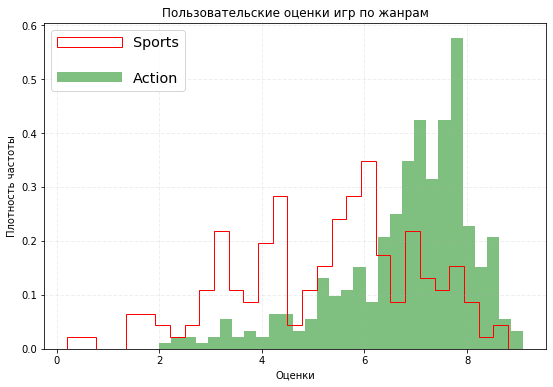

In [50]:
fig, ax = plt.subplots(figsize=(9,6))

ax.hist(games_action['user_score'], density=True, bins=30, color='green', alpha=0.5)
ax.hist(games_sports['user_score'], density=True, bins=30, color='red', histtype='step')
ax.set_title('Пользовательские оценки игр по жанрам')
ax.set_xlabel('Оценки')
ax.set_ylabel('Плотность частоты')
ax.grid(alpha=0.2, linestyle='--', linewidth=1)
ax.legend(["Sports", "Action"], loc=2, fontsize='x-large', labelspacing=1.5, handlelength=4.5)

Основания графиков похожи, но при этом идентичными их не назовешь. Оба распределения скошены влево. Но в пиках наблюдается расхождение. Распределение Action более крутое, пик выше и левее, чем в более пологом графике Sports. Это говорит о том, что у жанра Action гораздо больше высоких оценок.

Посчитаем средние значения.

In [51]:
print('Cредняя оценка пользователей, Action {:.2f}'.format(games_action['user_score'].mean()))
print('Cредняя оценка пользователей, Sports {:.2f}'.format(games_sports['user_score'].mean()))

Cредняя оценка пользователей, Action 6.84
Cредняя оценка пользователей, Sports 5.24


В среднем, пользователи оценивают игры жанра Action выше, чем Sports. Возможно, на это влияет сюжет игры. Оценим положение истинного среднего (mu), рассчитаем для него доверительный интервал.

In [52]:
print('Доверительный интервал для истинного среднего, Action', (st.t.interval(0.95, len(games_action['user_score'].dropna())-1, loc=np.mean(games_action['user_score'].dropna()), scale=st.sem(games_action['user_score'].dropna()))))
print('Доверительный интервал для истинного среднего, Sports', (st.t.interval(0.95, len(games_sports['user_score'].dropna())-1, loc=np.mean(games_sports['user_score'].dropna()), scale=st.sem(games_sports['user_score'].dropna()))))

Доверительный интервал для истинного среднего, Action (6.704933720639976, 6.970130546712208)
Доверительный интервал для истинного среднего, Sports (4.9596657314482115, 5.516584268551787)


С вероятностью 0.95 наши истинные средние будут находится в этих диапазонах.
Рассчитаем дисперсии для двух сегментов, используя поправку для степеней свободы.

In [53]:
print('Дисперсия пользовательских оценок, Action: {:.2f}'.format(np.var(games_action['user_score']), ddof=1))
print('Дисперсия пользовательских оценок, Sports: {:.2f}'.format(np.var(games_sports['user_score']), ddof=1))
print('Отношение дисперсий Sports и Action: {:.2f}'.format(np.var(games_sports['user_score']) / np.var(games_action['user_score'])))

Дисперсия пользовательских оценок, Action: 1.76
Дисперсия пользовательских оценок, Sports: 3.16
Отношение дисперсий Sports и Action: 1.79


Дисперсии двух выборок отличаются друг от друга. Рассчитаем стандартное отклонение для выборочных совокупностей.

In [54]:
print('Стандартное отклонение, Action: {:.2f}'.format(np.std(games_action['user_score'], ddof=1)))
print('Стандартное отклонение, Sports: {:.2f}'.format(np.std(games_sports['user_score'], ddof=1)))

Стандартное отклонение, Action: 1.33
Стандартное отклонение, Sports: 1.78


Рассчитаем границы выбросов для обеих выборок.

In [55]:
low = st.t.interval(0.95, len(games_action['user_score'].dropna())-1, loc=np.mean(games_action['user_score'].dropna()), scale=st.sem(games_action['user_score'].dropna()))[0] - (np.std(games_action['user_score'].dropna(), ddof=1))*3
up = st.t.interval(0.95, len(games_action['user_score'].dropna())-1, loc=np.mean(games_action['user_score'].dropna()), scale=st.sem(games_action['user_score'].dropna()))[1] + (np.std(games_action['user_score'].dropna(), ddof=1))*3
print('Границы выбросов для жанра Action {:.2f}'.format(low), '{:.2f}'.format(up))

low = st.t.interval(0.95, len(games_sports['user_score'].dropna())-1, loc=np.mean(games_sports['user_score'].dropna()), scale=st.sem(games_sports['user_score'].dropna()))[0] - (np.std(games_sports['user_score'].dropna(), ddof=1))*3
up = st.t.interval(0.95, len(games_sports['user_score'].dropna())-1, loc=np.mean(games_sports['user_score'].dropna()), scale=st.sem(games_sports['user_score'].dropna()))[1] + (np.std(games_sports['user_score'].dropna(), ddof=1))*3
print('Границы выбросов для жанра Sports {:.2f}'.format(low), '{:.2f}'.format(up))

Границы выбросов для жанра Action 2.71 10.96
Границы выбросов для жанра Sports -0.39 10.87


Сравним с границами выбросов, рассчитанных как 1,5 межквартильного размаха.

In [56]:
outliers_up = ((games_action['user_score'].describe()['75%'] - games_action['user_score'].describe()['25%'])*1.5 + games_action['user_score'].describe()['75%']).round(1)
outliers_down = (games_action['user_score'].describe()['25%'] - (games_action['user_score'].describe()['75%'] - games_action['user_score'].describe()['25%'])*1.5).round(1)
print('Границы выбросов по боксплотам, Action: {:.2f}'.format(outliers_down), '{:.2f}'.format(outliers_up))

outliers_up = ((games_sports['user_score'].describe()['75%'] - games_sports['user_score'].describe()['25%'])*1.5 + games_sports['user_score'].describe()['75%']).round(1)
outliers_down = (games_sports['user_score'].describe()['25%'] - (games_sports['user_score'].describe()['75%'] - games_sports['user_score'].describe()['25%'])*1.5).round(1)
print('Границы выбросов по боксплотам, Sports: {:.2f}'.format(outliers_down), '{:.2f}'.format(outliers_up))

Границы выбросов по боксплотам, Action: 4.00 10.00
Границы выбросов по боксплотам, Sports: 0.50 10.10


Боксплоты сильно ограничили размах оценок для выборочной совокупности. Удалим выбросы по нижней границе, равной 2.71. Предварительно посчитаем их долю.

In [57]:
print('Доля выбросов, Action: {:.4f}'.format(games_action.query('user_score < 2.71')['user_score'].count()/len(games_action)))
games_action = games_action.query('user_score >= 2.71')

print('Доля выбросов, Sports: {:.4f}'.format(games_sports.query('user_score < 0')['user_score'].count()/len(games_sports)))
games_sports = games_sports.query('user_score >= 0')

Доля выбросов, Action: 0.0065
Доля выбросов, Sports: 0.0000


Для проверки гипотез рассчитаем уровень значимости, пороговое значение - 0.05. Поскольку отношение дисперсий равно 1.79, в параметре equal_var укажем False.

In [58]:
print(st.ttest_ind(games_action['user_score'], games_sports['user_score'], equal_var=False), '\n')
if st.ttest_ind(games_action['user_score'], games_sports['user_score'], equal_var=False)[1] < 0.05:
    print('Нулевая гипотеза отвергнута, принята альтернативная')
else:
    print('Нулевая гипотеза не отвергается')

Ttest_indResult(statistic=10.735994662708922, pvalue=5.5759211993437465e-22) 

Нулевая гипотеза отвергнута, принята альтернативная


Значение p-value очень маленькое. Это значит, что мы можем отклонить нулевую гипотезу о равенстве средних оценок пользователей по жанрам Action и Sports, и принять альтернативную (средние в этих двух группах разные).

### Вывод

В разделе проверены две гипотезы о равенстве двух групп:
1. средних пользовательских рейтингов платформ Xbox One и PC;
2. средних пользовательских рейтингов жанров Action и Sports.

Критерием для оценки послужил уровень значимости с заданным порогом в 0.05. 
В первом случае у нас не оказалось достаточных оснований, чтобы отвергнуть нулевую гипотезу. То есть средние пользовательские рейтинги платформ Xbox One и PC мы можем считать равными. Во втором случае нулевая гипотеза была отклонена и принята альтернативная: средние пользовательские рейтинги жанров Action и Sports разные, будем считать, что они отличаются друг от друга.

Необходимо отметить, что в случае с платформами значение p-value равно 0.075, что не так уж и далеко от установленного нами предела. Это значит, что если мы останемся верны нулевой гипотезе (что средние двух групп равны), то точно такой же результат, какой мы наблюдаем, можно получить с вероятностью 7,5% (или в 7-8 случаях из 100). Это значит, что мы считаем основной нулевую гипотезу, но не можем однозначно утверждать, что она верна. Мы лишь не нашли значимых отличий между группами.

Во втором случае альтернативная гипотеза (что средние пользовательские рейтинги жанров Action и Sports не равны) кажется более убедительной. Здесь p-value - это очень маленькая цифра, с большим количеством нулей после запятой.

## Общий вывод

В работе изучена общая статистика по продажам игр в разрезах по годам, платформам и жанрам. Примерный жизненный цикл каждой консоли - около 7-10 лет, а разница между выходами поколений - 6-7 лет. В качестве альтернативного был взят период с 2013 года.

Самыми перспективными продуктами оказались игры для платформ PS4, XOne и 3DS. Вывод был сделан на основе анализа продаж за 2016 год.

Выявлена небольшая положительная зависимость между количеством проданных копий и оценками критиков, а вот корреляции между продажами и отзывами пользователей не обнаружено. 

Среди самых популярных жанров Action, Shooter и Sports. В целом, предпочтения потребителей одинаковы по всему миру, но Япония является исключением из правил. Здесь выбирают Role-Playing, Action и Misc. Похожая картина наблюдается и с платформами. Если во всех странах лидирует PS4, то в Японии на первом месте Nintendo. Игры здесь покупают больше для всей семьи или подростков, в то время как остальной мир останавливает свой выбор на играх взрослой категории.

Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC была принята, а вот о равенстве средних пользовательских рейтингов жанров Action и Sports отвергнута. Однако, всегда есть вероятность (хоть и небольшая), что наши выводы могут быть неверными.

Также нужно понимать, что огромное влияние на продажи имеет качество самой игры, ее сюжет, проработанность деталей, наличие или отсутствие багов и прочие характеристики. И недавний выход Cyberpunk 2077 еще раз заставил всех об этом вспомнить. 

Иногда на доходы могут повлиять совсем неожиданные факторы. Например, такое несвязанное с играми событие, как поедание летучих мышей, способно резко поднять продажи по всему миру. Кроме того, образовался целый пласт ностальгирующих кастомеров, которые с удовольствием проводят время с 8-битными игрушками.